# Topic Modeling on Research Papers

This project aims to build topic models on one of my research papers.

I recently published a research paper about academic self-concept formation at Contemporary Educational Psychology journal, which you can find at https://doi.org/10.1016/j.cedpsych.2022.102138 .

The dataset is in PDF form that I managed preprocessing before working on it in python. 


## The Main Objective


*   "Can there be a systematic way to extract topics of individual research paper?"
*   "Is there a way to decide the optimal number of topics for each research paper?"

In academic field, it is important to identify some key topics or themes from papers for the purpose of arrangements or publication. For this, scholars often read the entire paper to elicit the key topics and themes, which takes times and energy. In addition, the number of "highlights" of the paper has been decided by the arbitrary decision of individual scholars.

Concerning efficiecy in work, I organized the current project to find a systematic method to automatically identify some key themes or topics from each research paper using unsupervised learning. 

This technique can be applied to other situation in which efficient topic extraction is required such as news article, blog, social media and so on. 

Below I showcase an example of the topic extraction of my research paper using unsupervised learning technique. 

## Download Data and Dependencies

In [27]:
import os
import numpy as np
import pandas as pd

In [1]:
!pip install pdfquery
from pdfquery import PDFQuery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 60.8 MB/s eta 0:00:00
  Created wheel for pdfquery: filename=pdfquery-0.4.3-py3-none-any.whl size=16798 sha256=fefb722b96707555da6e19ab434f96c05d43ca37539981ec2f5c14dca573bb31
  Stored in directory: /root/.cache/pip/wheels/9a/12/58/c1c92713b406092cae17f51b6d67ee96c60675c78e7278eb38
Successfully built pdfquery


In [8]:
!pip install tqdm
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [28]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
pdf = PDFQuery('/Kim et al (2023). Article.pdf')
pdf.load()

# Use CSS-like selectors to locate the elements
text_elements = pdf.pq('LTTextLineHorizontal')

# Extract the text from the elements
papers = [t.text for t in text_elements]

print(papers)

['What Happens With Comparison Processes When “the Other” is Very ', 'Similar? Academic Self-Concept Formation in Twins ', 'Yeeun Kim a, *, Hanna Gaspard a, b, Moritz Fleischmann a, Benjamin Nagengast a,c, ', 'Ulrich Trautwein a ', 'a Hector Research Institute of Education Sciences and Psychology, University of Tübingen, Walter-Simon-Str. 12, 72072 Tübingen, Germany ', 'b Center for Research on Education and School Development, TU Dortmund University, Vogelpothsweg 78, 44227 Dortmund, Germany ', 'c Department of Education and the Brain & Motivation Research Institute (bMRI), Korea University, 145 Anam-ro, Seongbuk-gu, Seoul 02841, South Korea ', '', '', 'Keywords: ', 'Academic self-concept ', 'Social comparison ', 'I/E model ', 'Mirror effect ', 'Twin ', 'Age-difference ', 'According to the internal/external frame of reference (I/E) model (Marsh, 1986), individuals’ academic self- ', 'concept is strongly influenced by comparing their achievement in one domain with their achievement in 

## Basic Text Pre-processing

I perform some basic text wrangling / preprocessing.

In [10]:
%%time
import nltk
import tqdm

stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+') # can also use nltk.word_tokenize to get word tokens for each paper
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in tqdm.tqdm(papers):
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1] # removing any single character words \ numbers \ symbols 
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
            
    return norm_papers
    
norm_papers = normalize_corpus(papers)
print(len(norm_papers))

100%|██████████| 2288/2288 [00:00<00:00, 31397.24it/s]

1498
CPU times: user 75.7 ms, sys: 0 ns, total: 75.7 ms
Wall time: 77.9 ms


In [15]:
print(norm_papers[0][:50])

['happens', 'comparison', 'process']


## Build a Bi-gram Phrase Model

In this section, I extract some useful bi-gram
based phrases from our research paper and remove some unnecessary terms. I
leverage the very useful gensim.models.Phrases class for this. This technique
automatically detect common phrases from a stream of sentences, which are typically multi-word expressions/word n-grams. 

First, I start by extracting and generating words and bi-grams as phrases for
each tokenized research paper. 

The `min_count` parameter refers to ignore all words and bi-grams with total
collected count lower than 20 across the corpus (of the input paper as a list of tokenized
sentences). 

The `threshold` parameter of 20, refers to that the model accepts specific
phrases based on this threshold value so that a phrase of words a followed by b is accepted if the score of the phrase is greater than the threshold of 20. This threshold depends on the scoring parameter, which helps us understand how these phrases are scored to understand their influence.

Typically the default scorer is used and it’s pretty straightforward to understand.

In [16]:
!pip install gensim==3.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 58.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.6.0-cp39-cp39-linux_x86_64.whl size=23915434 sha256=3dbf1218a7ede67d05135a8334bfd4b02f9bea7dadc91b5c77b2c11a0d4bfc96
  Stored in directory: /root/.cache/pip/wheels/61/12/f2/84de20fba5e870553796b0834d11109992f06ddc20aaead086
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.1
    Uninstalling gensim-4.3.1:
      Successfully uninstalled gensim-4.3.1


In [17]:
import gensim
gensim.__version__ # version 3.6 needed to run MALLET LDA models

'3.6.0'

In [18]:
import gensim

bigram = gensim.models.Phrases(norm_papers, min_count=20, threshold=20, delimiter=b'_') # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[norm_papers[0]][:50]) # very similar to using ngram_range=(1,2) in count vectorizer

['happens', 'comparison', 'process']


In [19]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

# Create a dictionary representation of the documents.
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)   #every word is encoded with numbers. e.g., ability will be in the 7th columns. 
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, 'comparison'), (1, 'happens'), (2, 'process'), (3, 'academic'), (4, 'concept'), (5, 'formation'), (6, 'self'), (7, 'similar'), (8, 'twin'), (9, 'benjamin'), (10, 'fleischmann'), (11, 'gaspard'), (12, 'hanna'), (13, 'kim'), (14, 'moritz')]
Total Vocabulary Size: 1706


Looks like we have a lot of unique phrases in our research paper,
based on the preceding output. Several of these terms are not very useful since they are
too specific. Hence, it is time to prune
our vocabulary and start removing terms. Leveraging document frequency is a great way
to achieve this. 

In [20]:
# Filter out words that occur less than 20 times, or more than 60% of the document.
dictionary.filter_extremes(no_below=20, no_above=0.6) # similar to min_df and max_df in count vectorizer
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 60


I removed all terms that occur fewer than 20 times across our research paper and all
terms that occur in more than 60% of all the documents. I am interested in finding
different themes and topics and not recurring themes. Hence, this suits my intention
perfectly.

## Transforming corpus into bag of words vectors

Now I perform feature engineering by leveraging a simple Bag of Words
model.

In [21]:
# Transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

[(2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


In [22]:
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[1][:50]])

[('academic', 1), ('concept', 1), ('self', 1), ('similar', 1), ('twin', 1)]


In [23]:
print('Total number of papers:', len(bow_corpus))

Total number of papers: 1498


## Topic Models with Latent Dirichlet Allocation (LDA)

The Latent Dirichlet Allocation (LDA) technique is a generative probabilistic model in
which each document is assumed to have a combination of topics similar to a probabilistic
Latent Semantic Indexing model. In this case, the latent topics contain a Dirichlet
prior over them. The math behind in this technique is pretty involved, so we will try to
summarize it since going it specific details is out of the current scope.

![](https://i.imgur.com/l23JAvE.png)

Simplyfying the LDA model process:

![](https://i.imgur.com/0BXCaUi.png)

![](https://i.imgur.com/ioiUAxX.png)

In [24]:
%%time
TOTAL_TOPICS = 10
lda_model = gensim.models.LdaModel(corpus=bow_corpus, 
                                   id2word=dictionary, 
                                   chunksize=1740, 
                                   alpha='auto', 
                                   eta='auto', 
                                   random_state=42,
                                   iterations=500, 
                                   num_topics=TOTAL_TOPICS, 
                                   passes=20, 
                                   eval_every=None)

CPU times: user 7.6 s, sys: 103 ms, total: 7.7 s
Wall time: 7.59 s


In [25]:
for topic_id, topic in lda_model.print_topics(num_topics=10, num_words=20):  #10 most influential topics 
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.241*"self" + 0.187*"concept" + 0.184*"academic" + 0.106*"student" + 0.062*"process" + 0.057*"comparison" + 0.044*"similar" + 0.034*"mirror_effect" + 0.022*"marsh" + 0.015*"individual" + 0.011*"educational" + 0.009*"others" + 0.008*"contrast" + 0.007*"older" + 0.002*"achievement" + 0.001*"twin" + 0.001*"group" + 0.000*"effect" + 0.000*"wa" + 0.000*"test"

Topic #2:
0.176*"self" + 0.176*"concept" + 0.173*"german" + 0.139*"effect" + 0.119*"mathematics" + 0.089*"grade" + 0.044*"contrast" + 0.036*"table" + 0.022*"others" + 0.011*"academic" + 0.001*"older" + 0.001*"twin" + 0.001*"student" + 0.001*"wa" + 0.000*"test" + 0.000*"achievement" + 0.000*"comparison" + 0.000*"mirror_effect" + 0.000*"et_al" + 0.000*"year_old"

Topic #3:
0.221*"school" + 0.209*"grade" + 0.145*"data" + 0.097*"reported" + 0.088*"analysis" + 0.054*"mathematics" + 0.054*"self" + 0.042*"student" + 0.028*"variable" + 0.019*"two" + 0.013*"test" + 0.003*"wa" + 0.002*"twin" + 0.001*"difference" + 0.001*"concept" + 0

In [29]:
topics_coherences = lda_model.top_topics(bow_corpus, topn=20)
avg_coherence_score = np.mean([item[1] for item in topics_coherences])
print('Avg. Coherence Score:', avg_coherence_score)

Avg. Coherence Score: -8.220130962732583


Topic coherence is used to measure the
quality of topic models. Typically, a set of statements is said to be
coherent if they support each other. Topic models are unsupervised learning based
models that are trained on unstructured text data, making it difficult to measure the
quality of outputs. 


In [31]:
topics_with_wts = [item[0] for item in topics_coherences]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([(term, round(wt, 3)) for wt, term in topic])
    print()

LDA Topics with Weights
Topic #1:
[('achievement', 0.184), ('et_al', 0.17), ('wa', 0.131), ('found', 0.125), ('personality', 0.069), ('oller', 0.062), ('marsh', 0.048), ('academic', 0.047), ('effect', 0.034), ('contrast', 0.025), ('student', 0.025), ('domain', 0.015), ('journal', 0.014), ('others', 0.014), ('older', 0.013), ('comparison', 0.002), ('social', 0.002), ('self', 0.002), ('twin', 0.002), ('concept', 0.002)]

Topic #2:
[('twin', 0.441), ('co', 0.206), ('achievement', 0.141), ('mathematics', 0.049), ('effect', 0.046), ('german', 0.026), ('grade', 0.023), ('pair', 0.02), ('path', 0.015), ('self', 0.006), ('concept', 0.005), ('test', 0.004), ('older', 0.003), ('showed', 0.002), ('wa', 0.001), ('academic', 0.001), ('individual', 0.0), ('mz', 0.0), ('mirror_effect', 0.0), ('comparison', 0.0)]

Topic #3:
[('group', 0.241), ('domain', 0.201), ('age', 0.11), ('within', 0.104), ('across', 0.098), ('two', 0.039), ('concept', 0.026), ('achievement', 0.022), ('self', 0.02), ('twin', 0.01

In [32]:
print('LDA Topics without Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([term for wt, term in topic])
    print()

LDA Topics without Weights
Topic #1:
['achievement', 'et_al', 'wa', 'found', 'personality', 'oller', 'marsh', 'academic', 'effect', 'contrast', 'student', 'domain', 'journal', 'others', 'older', 'comparison', 'social', 'self', 'twin', 'concept']

Topic #2:
['twin', 'co', 'achievement', 'mathematics', 'effect', 'german', 'grade', 'pair', 'path', 'self', 'concept', 'test', 'older', 'showed', 'wa', 'academic', 'individual', 'mz', 'mirror_effect', 'comparison']

Topic #3:
['group', 'domain', 'age', 'within', 'across', 'two', 'concept', 'achievement', 'self', 'twin', 'academic', 'difference', 'analysis', 'older', 'pattern', 'mirror_effect', 'variable', 'others', 'test', 'mz']

Topic #4:
['self', 'concept', 'academic', 'student', 'process', 'comparison', 'similar', 'mirror_effect', 'marsh', 'individual', 'educational', 'others', 'contrast', 'older', 'achievement', 'twin', 'group', 'effect', 'wa', 'test']

Topic #5:
['self', 'concept', 'german', 'effect', 'mathematics', 'grade', 'contrast', '

## Evaluating topic model quality

Below, I show the perplexity and coherence scores as measures to evaluate the topic
model. Typically, lower the perplexity, the better the model. Similarly, the lower the
UMass score and the higher the Cv score in coherence, the better the model.

In [33]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, 
                                                      corpus=bow_corpus, 
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary, 
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, 
                                                         corpus=bow_corpus, 
                                                         texts=norm_corpus_bigrams,
                                                         dictionary=dictionary, 
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.366093940445557
Avg. Coherence Score (UMass): -8.220130962732583
Model Perplexity: -3.810052338402869


## LDA Models with MALLET

The MALLET framework is a Java-based package for statistical natural language
processing, document classification, clustering, topic modeling, information extraction,
and other machine learning applications to text. MALLET stands for MAchine Learning
for LanguagE Toolkit. It was developed by Andrew McCallum along with several people
at the University of Massachusetts Amherst. The MALLET topic modeling toolkit
contains efficient, sampling-based implementations of Latent Dirichlet Allocation,
Pachinko Allocation, and Hierarchical LDA. To use MALLET’s capabilities, we need to
download the framework.

In [34]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip -q mallet-2.0.8.zip

--2023-04-02 10:36:54--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2023-04-02 10:36:54--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  63.0MB/s    in 0.2s    

2023-04-02 10:36:55 (63.0 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [35]:
MALLET_PATH = 'mallet-2.0.8/bin/mallet'
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, 
                                              corpus=bow_corpus, 
                                              num_topics=TOTAL_TOPICS, 
                                              id2word=dictionary,
                                              iterations=500, 
                                              workers=4)

In [36]:
cv_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, 
                                                             corpus=bow_corpus, 
                                                             texts=norm_corpus_bigrams,
                                                             dictionary=dictionary, 
                                                             coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda_mallet.get_coherence()

umass_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                                texts=norm_corpus_bigrams,
                                                                dictionary=dictionary,  
                                                                coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda_mallet.get_coherence()

# from STDOUT: <500> LL/token: -8.52683
perplexity = -8.52683
print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.5312649567351002
Avg. Coherence Score (UMass): -13.735411262857971
Model Perplexity: -8.52683


![](https://i.imgur.com/yAYrq59.png)

## LDA Tuning: Finding the optimal number of topics

Finding the optimal number of topics in a topic model is tough, given that it is like a
model hyperparameter that you always have to set before training the model. I
use an iterative approach and build several models with differing numbers of topics and
select the one that has the highest coherence score. 

In [37]:
def topic_model_coherence_generator(corpus, texts, dictionary, 
                                    start_topic_count=2, end_topic_count=10, step=1,
                                    cpus=1):
    
    models = []
    coherence_scores = []
    for topic_nums in tqdm.tqdm(range(start_topic_count, end_topic_count+1, step)):
        mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, 
                                                            corpus=corpus,
                                                            num_topics=topic_nums, 
                                                            id2word=dictionary,
                                                            iterations=500, 
                                                            workers=cpus)
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model=mallet_lda_model, 
                                                                     corpus=corpus, 
                                                                     texts=texts, 
                                                                     dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(mallet_lda_model)
    
    return models, coherence_scores

In [38]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, 
                                                               texts=norm_corpus_bigrams,
                                                               dictionary=dictionary, 
                                                               start_topic_count=2,
                                                               end_topic_count=30, 
                                                               step=1, 
                                                               cpus=4)

100%|██████████| 29/29 [08:15<00:00, 17.08s/it]


In [39]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1),
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
21,23,0.5682
16,18,0.5557
27,29,0.5551
26,28,0.5545
28,30,0.5534
25,27,0.5519
22,24,0.5513
20,22,0.5493
14,16,0.5466
24,26,0.5457


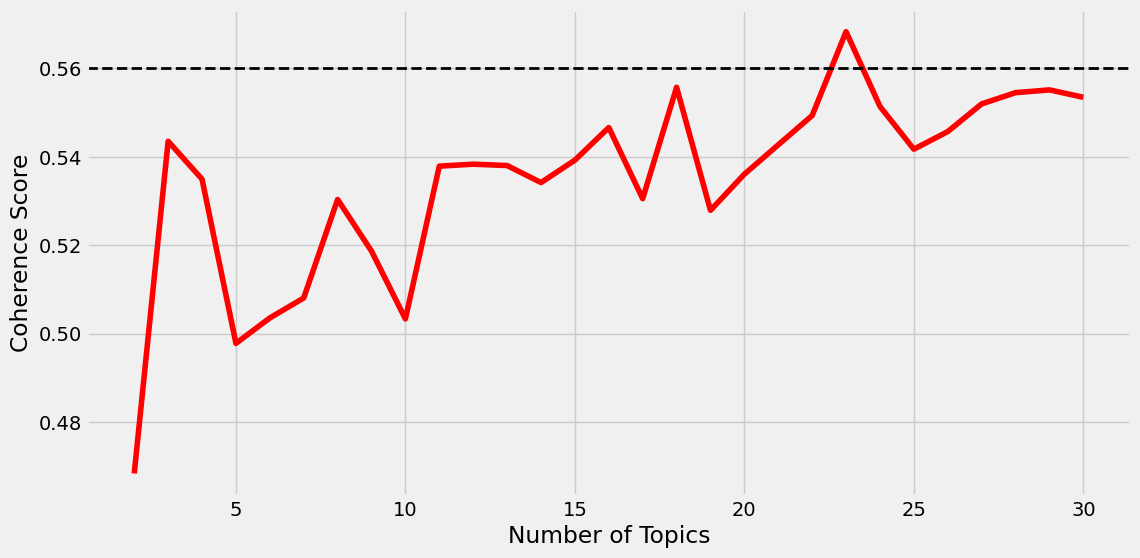

In [40]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(2, 31, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.5600, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

The above graph shows that the optical number of topics ranges in between 23 and 24 based on the coherence scoare. I choose the optimal number of topics as 23, accordingly. I can retrieve the best model as follow: 

In [41]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 23].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

23

In [43]:
best_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, 
                                                  corpus=bow_corpus, 
                                                  num_topics=23, 
                                                  id2word=dictionary,
                                                  iterations=500, 
                                                  workers=4)

In [44]:
best_lda_model.num_topics

23

In [45]:
topics = [[(term, round(wt, 3)) 
               for term, wt in best_lda_model.show_topic(n, topn=23)] 
                   for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['achievement', 'concept', 'academic', 'variable', 'pair', 'journal', 'cid', 'test', 'across', 'org', 'oller', 'analysis', 'educational', 'path', 'et_al', 'older', 'within', 'showed', 'pattern', 'wa', 'mz', 'study', 'fit']

Topic #2:
['twin', 'mirror_effect', 'pair', 'older', 'test', 'path', 'journal', 'fit', 'table', 'across', 'org', 'oller', 'analysis', 'study', 'educational', 'et_al', 'within', 'showed', 'pattern', 'wa', 'grade', 'cid', 'variable']

Topic #3:
['student', 'similar', 'comparison', 'table', 'internal', 'personality', 'oller', 'journal', 'path', 'org', 'across', 'analysis', 'study', 'et_al', 'variable', 'older', 'within', 'showed', 'pattern', 'wa', 'dz', 'educational', 'fit']

Topic #4:
['twin', 'mz', 'domain', 'test', 'cid', 'path', 'journal', 'fit', 'table', 'across', 'org', 'oller', 'analysis', 'study', 'educational', 'et_al', 'older', 'within', 'showed', 'pattern', 'wa', 'variable', 'dz']

Topic #5:
['et_al', 'variable', 'found', 'effect', 'individual', 'w

## Viewing LDA Model topics

In [47]:
topics_df = pd.DataFrame([[term for term, wt in topic] 
                              for topic in topics], 
                         columns = ['Term'+str(i) for i in range(1, 24)],
                         index=['Topic '+str(t) for t in range(1, best_lda_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23
Term1,achievement,twin,student,twin,et_al,twin,domain,cid,concept,analysis,...,mz,german,mathematics,social,effect,dz,twin,grade,research,http_doi
Term2,concept,mirror_effect,similar,mz,variable,data,data,wa,academic,regression,...,dz,grade,concept,journal,individual,year_old,achievement,school,marsh,org
Term3,academic,pair,comparison,domain,found,analysis,contrast,academic,model,difference,...,mirror_effect,mathematics,academic,study,mirror_effect,mz,effect,reported,study,psychology
Term4,variable,older,table,test,effect,school,mirror_effect,found,analysis,path,...,found,similar,journal,personality,fit,sample,grade,comparison,educational,similar
Term5,pair,test,internal,cid,individual,org,internal,individual,table,fit,...,path,personality,effect,pattern,path,oller,org,process,internal,test
Term6,journal,path,personality,path,wa,test,dz,journal,journal,dz,...,journal,variable,org,group,journal,path,within,student,twin,path
Term7,cid,journal,oller,journal,path,path,social,org,cid,table,...,pair,pair,pair,sample,personality,journal,path,psychology,table,journal
Term8,test,fit,journal,fit,journal,journal,journal,fit,dz,oller,...,table,path,path,org,table,pair,journal,oller,journal,pair
Term9,across,table,path,table,personality,fit,cid,path,across,journal,...,test,analysis,variable,cid,across,table,fit,journal,cid,table
Term10,org,across,org,across,pair,table,test,table,org,reported,...,across,study,test,path,org,org,table,path,group,across


In [48]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)]
                         )
topics_df

<ipython-input-48-8a50780ba5c5>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Topic1,"achievement, concept, academic, variable, pair, journal, cid, test, across, org, oller, analysis, educational, path, et_al, older, within, showed, pattern, wa, mz, study, fit"
Topic2,"twin, mirror_effect, pair, older, test, path, journal, fit, table, across, org, oller, analysis, study, educational, et_al, within, showed, pattern, wa, grade, cid, variable"
Topic3,"student, similar, comparison, table, internal, personality, oller, journal, path, org, across, analysis, study, et_al, variable, older, within, showed, pattern, wa, dz, educational, fit"
Topic4,"twin, mz, domain, test, cid, path, journal, fit, table, across, org, oller, analysis, study, educational, et_al, older, within, showed, pattern, wa, variable, dz"
Topic5,"et_al, variable, found, effect, individual, wa, path, journal, personality, pair, test, across, oller, org, study, cid, educational, older, within, showed, pattern, analysis, table"
Topic6,"twin, data, analysis, school, org, test, path, journal, fit, table, across, oller, educational, cid, et_al, older, within, showed, pattern, wa, mz, study, variable"
Topic7,"domain, data, contrast, mirror_effect, internal, dz, social, journal, cid, test, wa, org, oller, analysis, study, educational, et_al, older, within, showed, mz, table, path"
Topic8,"cid, wa, academic, found, individual, journal, org, fit, path, table, test, across, oller, analysis, educational, variable, et_al, older, within, showed, pattern, study, personality"
Topic9,"concept, academic, model, analysis, table, journal, cid, dz, across, org, oller, study, test, educational, et_al, older, within, showed, pattern, wa, grade, path, pair"
Topic10,"analysis, regression, difference, path, fit, dz, table, oller, journal, reported, pair, mathematics, study, older, et_al, cid, within, showed, pattern, wa, group, educational, variable"


## Interpreting Topic Model Results

An interesting point to remember is, given a corpus of documents (in the form of
features, e.g., Bag of Words) and a trained topic model, you can predict the distribution of
topics in each document (research paper in this case).

We can now get the most dominant topic per research paper with some intelligent
sorting and indexing.

In [49]:
print(bow_corpus[0][:30])

[(0, 1), (1, 1)]


In [50]:
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[0][:30]])

[('comparison', 1), ('process', 1)]


In [51]:
tm_results = best_lda_model[bow_corpus] 

In [52]:
tm_results[0]

[(0, 0.04180602006688965),
 (1, 0.04180602006688965),
 (2, 0.04180602006688965),
 (3, 0.04180602006688965),
 (4, 0.04180602006688965),
 (5, 0.04180602006688965),
 (6, 0.04180602006688965),
 (7, 0.04180602006688965),
 (8, 0.04180602006688965),
 (9, 0.04180602006688965),
 (10, 0.04180602006688965),
 (11, 0.04180602006688965),
 (12, 0.07599405425492384),
 (13, 0.04180602006688965),
 (14, 0.04180602006688965),
 (15, 0.04180602006688965),
 (16, 0.04180602006688965),
 (17, 0.04180602006688965),
 (18, 0.04180602006688965),
 (19, 0.04180602006688965),
 (20, 0.046079524340393925),
 (21, 0.04180602006688965),
 (22, 0.04180602006688965)]

In [53]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] 
                     for topics in tm_results]
corpus_topics[:5]
len(corpus_topics), len(papers)

(1498, 2288)

In [57]:
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(corpus_topics))
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Paper'] = [corpus_topics[:500] for paper in corpus_topics]

## Dominant Topics in Specific Research Papers

Another interesting perspective is to select specific papers, view the most dominant topic
in each of those papers, and see if that makes sense.

In [58]:
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], 
                                                                                         ascending=False)
                                                                             .iloc[0]))

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
Dominant Topic,,,,,
1,809,1,7.39,"achievement, concept, academic, variable, pair, journal, cid, test, across, org, oller, analysis, educational, path, et_al, older, within, showed, pattern, wa, mz, study, fit","[(12, 0.07599405425492384), (2, 0.05671855430309535), (0, 0.04347826086956519), (0, 0.04347826086956519), (21, 0.06103678929765889), (20, 0.06103678929765888), (21, 0.062233589087809064), (0, 0.04347826086956519), (8, 0.05890003716090675), (16, 0.06103678929765888), (10, 0.06223358908780905), (1, 0.055697641375390766), (3, 0.05134034290044522), (9, 0.06103678929765889), (21, 0.065788317962231), (0, 0.06289139380926818), (6, 0.07453416149068319), (8, 0.0628913938092682), (1, 0.05569227964634036), (17, 0.07184892402283706), (8, 0.06461352657004828), (10, 0.059885151763740783), (15, 0.065788317962231), (10, 0.05667701863354037), (11, 0.0758893280632411), (19, 0.0796268532400466), (8, 0.07712518010000846), (6, 0.06083378064054391), (1, 0.06103678929765888), (6, 0.05988515176374077), (8, 0.06407802388114121), (4, 0.06103678929765889), (8, 0.05569764137539075), (0, 0.05359584358764014), (4, 0.062233589087809064), (4, 0.06103678929765889), (0, 0.04347826086956519), (8, 0.06531029357116315), (6, 0.059885151763740783), (21, 0.062233589087809064), (21, 0.05988515176374077), (10, 0.059885151763740783), (21, 0.07790953008344312), (2, 0.06103678929765889), (6, 0.060054939850336296), (10, 0.05988515176374078), (6, 0.059885151763740783), (4, 0.05877616747181963), (12, 0.07112184648416532), (21, 0.059885151763740783), (12, 0.06906423331544102), (8, 0.06407802388114121), (8, 0.0661744599398414), (2, 0.059885151763740783), (2, 0.07317945965288956), (12, 0.06780851998243304), (6, 0.05877616747181963), (2, 0.06407802388114121), (0, 0.04347826086956519), (22, 0.062233589087809064), (2, 0.05890003716090675), (6, 0.06103678929765889), (16, 0.06103678929765888), (8, 0.05351899213791799), (6, 0.05877616747181963), (15, 0.06005493985033628), (8, 0.06827089599854162), (17, 0.05988515176374077), (8, 0.05877616747181963), (21, 0.0661744599398414), (12, 0.06103678929765889), (4, 0.062233589087809064), (2, 0.05134034290044522), (17, 0.07246376811594205), (12, 0.0661744599398414), (8, 0.05462653288740246), (6, 0.059885151763740783), (0, 0.04347826086956519), (12, 0.08084951235074286), (0, 0.04347826086956519), (6, 0.059885151763740783), (2, 0.08084951235074286), (10, 0.06223358908780905), (7, 0.055697641375390766), (16, 0.06103678929765888), (2, 0.063173541434411), (2, 0.06103678929765888), (0, 0.04347826086956519), (6, 0.051340342900445216), (17, 0.07665664023334244), (17, 0.05988515176374078), (0, 0.055697641375390766), (3, 0.065788317962231), (16, 0.057788715705040565), (6, 0.0772946859903381), (21, 0.0738573021181717), (11, 0.05988515176374078), (13, 0.07184892402283707), (2, 0.08026755852842811), (6, 0.07456020417464224), ...]"
2,400,2,7.88,"twin, mirror_effect, pair, older, test, path, journal, fit, table, across, org, oller, analysis, study, educational, et_al, within, showed, pattern, wa, grade, cid, variable","[(12, 0.07599405425492384), (2, 0.05671855430309535), (0, 0.04347826086956519), (0, 0.04347826086956519), (21, 0.06103678929765889), (20, 0.06103678929765888), (21, 0.062233589087809064), (0, 0.04347826086956519), (8, 0.05890003716090675), (16, 0.06103678929765888), (10, 0.06223358908780905), (1, 0.055697641375390766), (3, 0.05134034290044522), (9, 0.06103678929765889), (21, 0.065788317962231), (0, 0.06289139380926818), (6, 0.07453416149068319), (8, 0.0628913938092682), (1, 0.05569227964634036), (17, 0.07184892402283706), (8, 0.06461352657004828), (10, 0.059885151763740783), (15, 0.065788317962231), (10, 0.05667701863354037), (11, 0.0758893280632411), (19, 0.0796268532400466), (8, 0.07712518010000846), (6, 0.06083378064054391), (1, 0.06103678929765888), (6, 0.05988515176374077), (8, 0.06407802388114121), (4, 0.06103678929765889), (8, 0.05569764137539075), (0, 0.05359584358764014),